##### ARTI 560 - Computer Vision  
## Image Classification using Transfer Learning - Exercise 

### Objective

In this exercise, you will:

1. Select another pretrained model (e.g., VGG16, MobileNetV2, or EfficientNet) and fine-tune it for CIFAR-10 classification.  
You'll find the pretrained models in [Tensorflow Keras Applications Module](https://www.tensorflow.org/api_docs/python/tf/keras/applications).

2. Before training, inspect the architecture using model.summary() and observe:
- Network depth
- Number of parameters
- Trainable vs Frozen layers

3. Then compare its performance with ResNet and the custom CNN.

### Questions:

- Which model achieved the highest accuracy?
- Which model trained faster?
- How might the architecture explain the differences?

In [20]:
import tensorflow as tf
import numpy as np
import time

from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical


In [21]:
# Load data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

num_classes = 10
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat  = to_categorical(y_test, num_classes)

print("Train:", x_train.shape, y_train.shape)
print("Test :", x_test.shape, y_test.shape)


Train: (50000, 32, 32, 3) (50000, 1)
Test : (10000, 32, 32, 3) (10000, 1)


In [22]:
IMG_SIZE = 96
BATCH_SIZE = 64

# Mobilenetv2 preprocess
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess

def make_ds(x, y, training=True):
    ds = tf.data.Dataset.from_tensor_slices((x, y))
    if training:
        ds = ds.shuffle(10000)
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds_raw = make_ds(x_train, y_train_cat, training=True)
test_ds_raw  = make_ds(x_test,  y_test_cat,  training=False)

def mobilenet_map(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = mobilenet_preprocess(image)
    return image, label

train_ds_mn = train_ds_raw.map(mobilenet_map, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_mn  = test_ds_raw.map(mobilenet_map,  num_parallel_calls=tf.data.AUTOTUNE)


In [28]:
from tensorflow.keras.applications import MobileNetV2
import tensorflow.keras.backend as K

def build_mobilenetv2_model(num_classes=10):
    base = MobileNetV2(
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        include_top=False,
        weights="imagenet"
    )
    base.trainable = False 

    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = base(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inputs, outputs)
    return model, base

mobilenet_model, mobilenet_base = build_mobilenetv2_model(num_classes)

mobilenet_model.summary()

trainable_count = np.sum([K.count_params(w) for w in mobilenet_model.trainable_weights])
non_trainable_count = np.sum([K.count_params(w) for w in mobilenet_model.non_trainable_weights])

print("-" * 30)
print(f"Observation Results:")
print(f"1. Network Depth (Base Layers): {len(mobilenet_base.layers)}")
print(f"2. Trainable Parameters:        {trainable_count:,}")
print(f"3. Frozen (Non-Trainable):      {non_trainable_count:,}")
print("-" * 30)

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_96             │ (None, 3, 3, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,270,794 (8.66 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

------------------------------
Observation Results:
1. Network Depth (Base Layers): 154
2. Trainable Parameters:        12,810
3. Frozen (Non-Trainable):      2,257,984
------------------------------


In [24]:
mobilenet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5)
]

t0 = time.time()
hist_mn_frozen = mobilenet_model.fit(
    train_ds_mn,
    validation_data=test_ds_mn,
    epochs=5,
    callbacks=callbacks,
    verbose=1
)
mn_frozen_time = time.time() - t0

mn_frozen_eval = mobilenet_model.evaluate(test_ds_mn, verbose=0)
print("MobileNetV2 Frozen - Test loss/acc:", mn_frozen_eval, "Time(s):", round(mn_frozen_time,2))

Epoch 1/5


782/782 ━━━━━━━━━━━━━━━━━━━━ 84s 105ms/step - accuracy: 0.7876 - loss: 0.6268 - val_accuracy: 0.8443 - val_loss: 0.4414 - learning_rate: 0.0010
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 92s 118ms/step - accuracy: 0.8472 - loss: 0.4485 - val_accuracy: 0.8587 - val_loss: 0.4077 - learning_rate: 0.0010
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 104s 133ms/step - accuracy: 0.8556 - loss: 0.4223 - val_accuracy: 0.8568 - val_loss: 0.4034 - learning_rate: 0.0010
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 98s 125ms/step - accuracy: 0.8609 - loss: 0.4067 - val_accuracy: 0.8529 - val_loss: 0.4185 - learning_rate: 0.0010
Epoch 5/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 89s 114ms/step - accuracy: 0.8631 - loss: 0.3998 - val_accuracy: 0.8588 - val_loss: 0.4092 - learning_rate: 0.0010
MobileNetV2 Frozen - Test loss/acc: [0.403364896774292, 0.8568000197410583] Time(s): 467.8


In [25]:
# Unfreeze last N layers (example: last 30 layers)
mobilenet_base.trainable = True

fine_tune_at = len(mobilenet_base.layers) - 30
for layer in mobilenet_base.layers[:fine_tune_at]:
    layer.trainable = False

print("Total layers in base:", len(mobilenet_base.layers))
print("Fine-tune from layer:", fine_tune_at)
print("Trainable layers now:", sum([l.trainable for l in mobilenet_base.layers]))


Total layers in base: 154
Fine-tune from layer: 124
Trainable layers now: 30


In [26]:
mobilenet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # smaller LR for fine-tuning
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

t0 = time.time()
hist_mn_ft = mobilenet_model.fit(
    train_ds_mn,
    validation_data=test_ds_mn,
    epochs=3,
    callbacks=callbacks,
    verbose=1
)
mn_ft_time = time.time() - t0

mn_ft_eval = mobilenet_model.evaluate(test_ds_mn, verbose=0)
print("MobileNetV2 Fine-tuned - Test loss/acc:", mn_ft_eval, "Time(s):", round(mn_ft_time,2))

Epoch 1/3
782/782 ━━━━━━━━━━━━━━━━━━━━ 161s 200ms/step - accuracy: 0.8620 - loss: 0.4267 - val_accuracy: 0.8717 - val_loss: 0.4176 - learning_rate: 1.0000e-04
Epoch 2/3
782/782 ━━━━━━━━━━━━━━━━━━━━ 202s 259ms/step - accuracy: 0.9313 - loss: 0.1950 - val_accuracy: 0.8925 - val_loss: 0.3591 - learning_rate: 1.0000e-04
Epoch 3/3
782/782 ━━━━━━━━━━━━━━━━━━━━ 154s 197ms/step - accuracy: 0.9587 - loss: 0.1165 - val_accuracy: 0.8748 - val_loss: 0.4373 - learning_rate: 1.0000e-04
MobileNetV2 Fine-tuned - Test loss/acc: [0.3590506613254547, 0.8924999833106995] Time(s): 517.22


Which model achieved the highest accuracy?

The ResNet50V2 achieved the highest accuracy 91.6%. MobileNetV2 also performed well 89.2%, but it was slightly lower than ResNet. The Custom CNN had the lowest accuracy 70% because it was trained from scratch without using pretrained weights.

Which model trained faster?

MobileNetV2 trained faster than ResNet50V2. It has much fewer parameters around 2.2 million compared to ResNet50V2 around 23 million, so each epoch took less time.

The Custom CNN was also relatively fast since it is a small and simple model compared to the other two.

How might the architecture explain the differences?

ResNet is much deeper and uses residual connections, which help it learn more complex features. This is probably why it achieved the highest accuracy, but it also makes training slower.

MobileNet uses depthwise separable convolutions, which reduce the number of computations. That’s why it trains faster, but it is slightly less accurate than ResNet in this case.

The Custom CNN only has two convolutional layers and was trained from scratch. Since it doesn’t use pretrained features like the other models, its performance was lower.

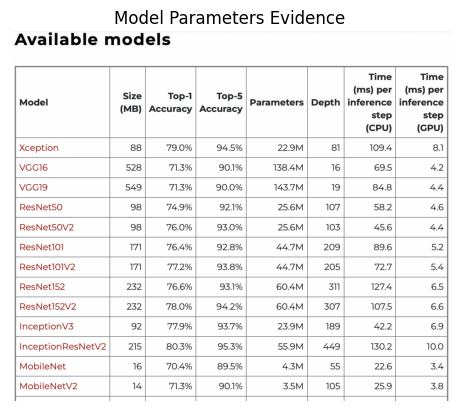

In [30]:
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open("/Users/norasmacbook/Desktop/Screenshot 2026-02-16 at 7.52.41 PM.png")   

plt.imshow(img)
plt.axis("off")
plt.title("Model Parameters Evidence")
plt.show()